# Local Interpretability

In [ ]:
#| hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#| default_exp core

In [ ]:
#| hide
%reload_ext autoreload
%autoreload 2

In [ ]:
#| exporti
from PIL import Image, ImageEnhance, ImageOps
from functools import partial
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
from io import BytesIO as Buffer

In [ ]:
from misas.fastai_model import Fastai2_model

## Evaluation functions

In [ ]:
#| exporti
def dice_by_component(predictedMask, trueMask, component = 1):
    """
    Calculates the dice score (the overlap between the mask predicted 
    by the model and the true mask that the user supplies, while 0 equals 
    no overlap and 1 equals 100% overlap)
    user supplies the predictedMask
    and trueMask through the function eval_generic_series, component's
    standard value is set to 1, but gets overwritten by 
    eval_generic_series)
    """
    dice = 1.0
    pred = np.array(predictedMask) == component
    msk = np.array(trueMask) == component
    intersect = pred&msk
    total = np.sum(pred) + np.sum(msk)
    if total > 0:
        dice = 2 * np.sum(intersect).astype(float) / total
    return dice

In [ ]:
#| exporti
def recall_by_component(predictedMask, trueMask, component = 1):
    """
    Calculates the recall score (percentage of trueMask that is included 
    in the overlap of trueMask and predictedMask)
    """
    recall = 1.0
    pred = np.array(predictedMask) == component
    msk = np.array(trueMask) == component
    intersect = pred&msk
    total = np.sum(pred) + np.sum(msk) 
    if total > 0:
        recall = np.sum(intersect).astype(float) / np.sum(msk)
    return recall

In [ ]:
#| exporti
def precision_by_component(predictedMask, trueMask, component = 1):
    """
    Calculates the precision score (percentage of predictedMask that is included 
    in the overlap of trueMask and predictedMask)
    """
    precision = 1.0
    pred = np.array(predictedMask) == component
    msk = np.array(trueMask) == component
    intersect = pred&msk
    total = np.sum(pred) + np.sum(msk) 
    if total > 0:
        precision = 0 
        if np.sum(pred) > 0:
            precision = np.sum(intersect).astype(float) / np.sum(pred)
    return precision

## Sensitivity Analysis

### Example data (kaggle)

In [ ]:
def label_func(x):
    pass
def acc_seg(input, target):
    pass
def diceComb(input, targs):
    pass
def diceLV(input, targs):
    pass
def diceMY(input, targs):
    pass

In [ ]:
#| hide_output
def img():
    """
    Opens the sample image as a PIL image
    """
    return Image.open("example/kaggle/images/1-frame014-slice005.png").convert("RGB")
#img = lambda: Image.open("example/kaggle/images/1-frame014-slice005.png")

def trueMask():
    """
    Opens the true mask as a PIL image
    """
    return Image.open("example/kaggle/masks/1-frame014-slice005.png").convert("I")
#trueMask = lambda: Image.open("example/kaggle/masks/1-frame014-slice005.png")
trainedModel = Fastai2_model("chfc-cmi/cmr-seg-tl", "cmr_seg_base")

Using cache found in /home/csa84mikl/.cache/torch/hub/chfc-cmi_cmr-seg-tl_master


### Default color map

Define a default color map for the sample image derived from `viridis` and a default color map for the true map derived from `plasma` but setting the color for class "0" to completely transparent.
This makes sense if class "0" is the background.

In [ ]:
#| exporti
from matplotlib import cm
from matplotlib.colors import ListedColormap

default_cmap = cm.viridis(np.arange(cm.viridis.N))
default_cmap[0][-1] = 0
default_cmap = ListedColormap(default_cmap)

default_cmap_true_mask = cm.plasma_r(np.arange(cm.plasma.N))
default_cmap_true_mask[0][-1] = 0
default_cmap_true_mask = ListedColormap(default_cmap_true_mask)

### Generic functions

In [ ]:
#| export
def get_generic_series(image,
        model,
        transform,
        truth=None,
        tfm_y=False,
        start=0,
        end=180,
        step=30,
        log_steps=False,
    ):
    """
    Generic function for transforming images.
    Input: image (PIP image, usually your sample image opened by img()),
    model (the function for your model that manages the prediction for your mask),
    transform (your specific transformation function), 
    truth = None (replaces with a true mask if available),
    tfm_y = False (set to True if your true mask has to be transformed as well to fit the
    transformed sample image e.g in case of a rotation of the sample image),
    start, end, step as values the transform function,
    log_steps = False (if enabled logarithmic steps as parameters 
    for the transform function are possible)
    Output: a list containing lists of [param, img, pred, trueMask] 
    after img and optionally trueMask have been transformed
    and pred has been determined by using a modell on the transformed img for each different param
    """
    series = []
    trueMask = None
    steps = np.arange(start,end,step)
    if log_steps:
        steps = np.exp2(np.linspace(np.log2(start),np.log2(end),round((np.log2(end)-np.log2(start))/np.log2(step)+1)))
    for param in tqdm(steps, leave=False):
        img = image
        img = transform(img, param)
        if hasattr(model,"prepareSize"):
            img = model.prepareSize(img)
        #pred = model.predict(img)[0]
        pred = model.predict(img)
        series.append([param,img,pred])
        if truth:
            trueMask = truth
            if tfm_y:
                trueMask = transform(trueMask, param)
            if hasattr(model,"prepareSize"):
                trueMask = model.prepareSize(trueMask)
        series[-1].append(trueMask)
    return series

In [ ]:
#| export
def plot_series(
        series,
        nrow=1,
        figsize=(16,6),
        param_name='param',
        overlay_truth=False,
        vmax=None,
        vmin=0,
        cmap=default_cmap,
        cmap_true_mask = default_cmap_true_mask,
        **kwargs
    ):
    """
    plots the transformed images with the prediction and optionally the true mask overlayed
    intput:
    series = a list containing lists of [param, img, pred, trueMask] from the function get_generic_series
    nrow = number of rows drawn with the transformed images
    figsize = (16,6)
    param_name='param',
    overlay_truth = False (if True displays the true mask 
    over the sample along with the prediction)
    vmax = None (controls how many colors the prediction is going to have, can be set manually by the user, 
    otherwise is deterimed by the max amount of colors in the prediction
    cmap= default_cmap (sets the default color map)
    output: a plot generated by mathplotlib
    """
    fig, axs = plt.subplots(nrow,int(np.ceil(len(series)/nrow)),figsize=figsize,**kwargs)
    #fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
    if vmax is None:
        vmax = max([x[2].getextrema()[1] for x in series])
        #vmax = x[1]
        if series[0][3]:
            vmax_truth = max([x[3].getextrema()[1] for x in series])
            vmax = max(vmax_truth, vmax)
    #if vmin is None:
    #    vmin = min([x[2].getextrema()[0] for x in series])
    #    if series[0][3]:
    #        vmin_truth = min([x[3].getextrema()[1] for x in series])
    #        vmin = min(vmin_truth, vmin)
    for element, ax in zip(series, axs.flatten()):
        param,img,pred,truth = element
        ax.imshow(np.array(img))
        ax.imshow(np.array(pred), vmax=vmax,cmap=cmap, vmin=vmin, alpha=.5, interpolation="nearest")
        ax.set_title(f"{param_name}:{np.around(param,decimals=2)}")
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        if overlay_truth and truth:
            ax.imshow(np.array(truth), alpha = 0.2, cmap = cmap_true_mask, interpolation="nearest")

In [ ]:
#| export
def plot_frame(param, img, pred, param_name="param",vmax=None, vmin=0, cmap=default_cmap,**kwargs):
    """
    plots the transformed images and prediction overlayed for the gif_series function
    """
    _,ax = plt.subplots(**kwargs)
    ax.imshow(img)
    ax.imshow(np.array(pred), vmax=vmax,cmap=cmap, vmin=vmin, alpha=.5, interpolation="nearest")
    ax.set_title(f"{param_name}:{np.around(param,decimals=2)}")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    buffer = Buffer() #thanks to https://github.com/maxhumber/gif/
    plt.savefig(buffer, format="png")
    plt.close()
    buffer.seek(0)
    img = Image.open(buffer)
    return img
    


In [ ]:
#| export
def gif_series(series, fname, duration=150, param_name="param", vmax=None, vmin=0, cmap=default_cmap):
    """
    creates a gif from the output of plot_frame
    """
    if vmax is None:
        vmax = max([x[2].getextrema()[1] for x in series])
    #if vmin is None:
    #    vmin = min([x[2].getextrema()[0] for x in series])
    frames = [plot_frame(*x[:3], param_name=param_name, vmax=vmax, cmap=cmap, vmin=vmin) for x in series]
    #gif.save(frames, fname, duration=duration)
    frames[0].save(fname,
               save_all = True, append_images = frames[1:],
               optimize = False, duration = duration, disposal=2, loop=0)

In [ ]:
#| export
def eval_generic_series(
        image,
        mask,
        model,
        transform_function,
        start=0,
        end=360,
        step=5,
        param_name="param",
        mask_transform_function=None,
        components=['bg', 'c1','c2'],
        eval_function=dice_by_component,
        mask_prepareSize=True
    ):
    """
    Perform the transformation on the sample, creates a prediction and 
    then uses the prediction and true mask to run an evaluation function 
    to measure the overlap between predicted mask and true mask
    """
    results = list()
    for param in tqdm(np.arange(start, end, step), leave=False):
        img = image
        img = transform_function(img, param)
        trueMask = mask
        if mask_transform_function:
            trueMask = mask_transform_function(trueMask, param)
        if hasattr(model,"prepareSize"):
            img = model.prepareSize(img)
            if mask_prepareSize:
                trueMask = model.prepareSize(trueMask)
        #prediction = model.predict(img)[0]
        prediction = model.predict(img)
        # prediction._px = prediction._px.float()
        result = [param]
        for i in range(len(components)):
            result.append(eval_function(prediction, trueMask, component = i))
        results.append(result)

    results = pd.DataFrame(results,columns = [param_name, *components])
    return results

In [ ]:
#| export
def plot_eval_series(results, chart_type="line", value_vars=None, value_name='Dice Score'):
    """
    Plots the resuls of the eval_generic_function
    """
    id_var = results.columns[0]
    if not value_vars:
        value_vars = results.columns[2:]
    plot = alt.Chart(results.melt(id_vars=[id_var],value_vars=value_vars, value_name=value_name))
    if chart_type=="line":
        plot = plot.mark_line()
    elif chart_type=="point":
        plot = plot.mark_point(size=80)
    else:
        raise ValueError(f'chart_type must be one of "line" or "point"')
    plot = plot.encode(
      x=id_var,
      y=value_name,
      color=alt.Color("variable"),#,legend=None),
      tooltip=value_name
    ).properties(width=700,height=300).interactive()
    return plot#.configure_axis(title=None,labels=False,ticks=False)

### Rotation

In [ ]:
#| export
def rotationTransform(image, deg):
    """
    rotates an image by x degrees (deg)
    """
    return image.rotate(int(deg))
    

def get_rotation_series(image, model, start=0, end=361, step=60, **kwargs):
    """ 
    runs the get_generic_series with rotationTransform as transform 
    """
    return get_generic_series(image,model,rotationTransform, start=start, end=end, step=step, tfm_y = True, **kwargs)

In [ ]:
series = get_rotation_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/7 [00:00<?, ?it/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


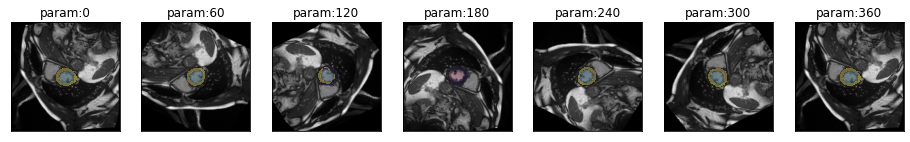

In [ ]:
plot_series(series, overlay_truth = True)

In [ ]:
#| export
def eval_rotation_series(image, mask, model, step=5, start=0, end=360,  param_name="deg", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        rotationTransform,
        start=start,
        end=end,
        step=step,
        mask_transform_function=rotationTransform,
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/72 [00:00<?, ?it/s]

alt.Chart(...)

You can easily generate gifs by plotting multiple frames

In [ ]:
gif_series(
    get_rotation_series(img(),trainedModel,start=0,end=360,step=5),
    "example/kaggle/rotation.gif",
    duration=500,
    param_name="degrees"
)

  0%|          | 0/72 [00:00<?, ?it/s]

![segmentation sensitivity to rotation](example/kaggle/rotation.gif)

### Cropping

In [ ]:
#| export
def cropTransform(image, pxls, finalSize = None):
    image = ImageOps.fit(image, (finalSize))
    image = ImageOps.crop(image, (pxls))
    image = ImageOps.crop(image, (-pxls))
    return image



def get_crop_series(image, model, start=0, end=256, step=10, finalSize = None, **kwargs):
    if finalSize == None:
        finalSize = image.size
    if type(finalSize) == int:
        finalSize = (finalSize, finalSize)
    if end >= min(finalSize)//2:
        end = min(finalSize)//2

    return get_generic_series(image,model,partial(cropTransform,finalSize=finalSize), start=start, end=end, step=step, tfm_y = True, **kwargs)

In [ ]:
series = get_crop_series(img(), trainedModel, truth=trueMask(), step=10)

  0%|          | 0/12 [00:00<?, ?it/s]

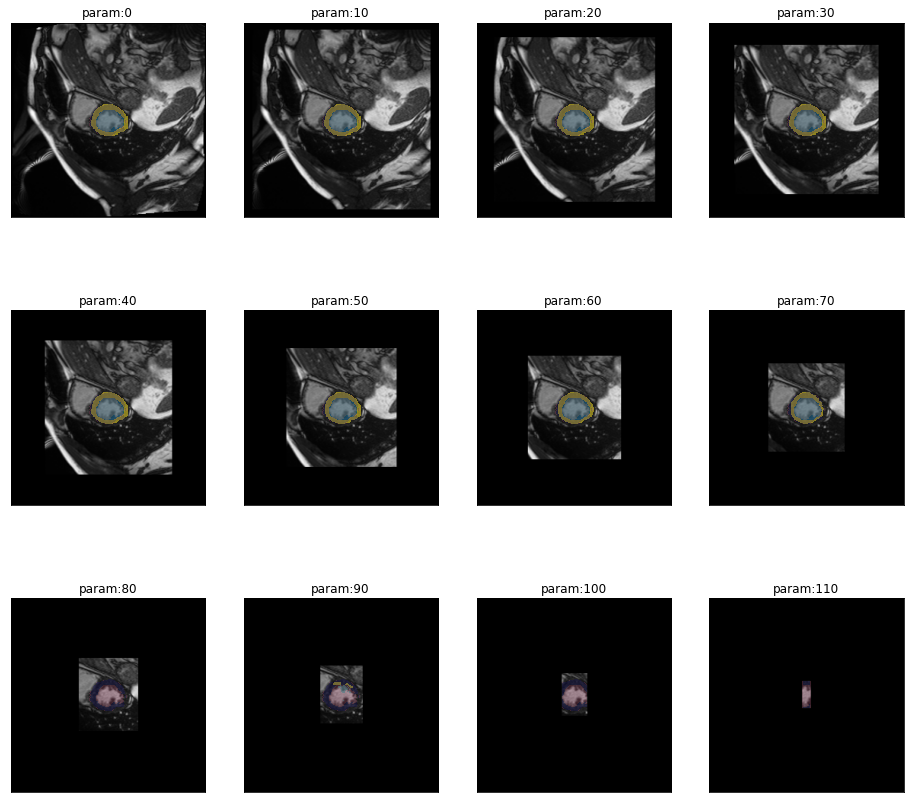

In [ ]:
plot_series(series,nrow=3,figsize=(16,15), overlay_truth = True) #,overlay_truth=True)

In [ ]:
#| export
def eval_crop_series(image, mask, model, step=10, start=0, end=256, finalSize=None, param_name="pixels", **kwargs):
    finalmaskSize = finalSize
    if finalSize == None:
        finalSize = image.size
        finalmaskSize = mask.size
    if type(finalSize) == int:
        finalSize = (finalSize, finalSize)
        finalmaskSize = mask.size
    if end >= min(finalSize)//2:
        end = min(finalSize)//2
    return eval_generic_series(
        image,
        mask,
        model,
        partial(cropTransform,finalSize=finalSize),
        start=start,
        end=end,
        step=step,
        mask_transform_function=partial(cropTransform,finalSize=finalmaskSize),
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_crop_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/12 [00:00<?, ?it/s]

alt.Chart(...)

Cropping and comparing to the full original mask might not be desired. In this case it is possible to crop the mask as well. All pixels in the cropped area are set to 0 (commonly the background class). As soon as a class is completely missing, the dice score might jump to 1 because not predicting the class is correct in that case.

In [ ]:
gif_series(
    get_crop_series(img(),trainedModel,start=0,end=256,step=5),
    "example/kaggle/crop.gif",
    duration=500,
    param_name="pixels"
)

  0%|          | 0/23 [00:00<?, ?it/s]

![segmentation sensitivity to cropping](example/kaggle/crop.gif)

### Brightness

In [ ]:
#| export
def brightnessTransform(image, light):
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance (light)
    return image    

def get_brightness_series(image, model, start=0.25, end=8, step=np.sqrt(2), log_steps = True, **kwargs):
    return get_generic_series(image,model,brightnessTransform, start=start, end=end, step=step, log_steps=log_steps, **kwargs)

In [ ]:
series = get_brightness_series(img(), trainedModel, truth=trueMask(), start=1/8, end=16)

  0%|          | 0/15 [00:00<?, ?it/s]

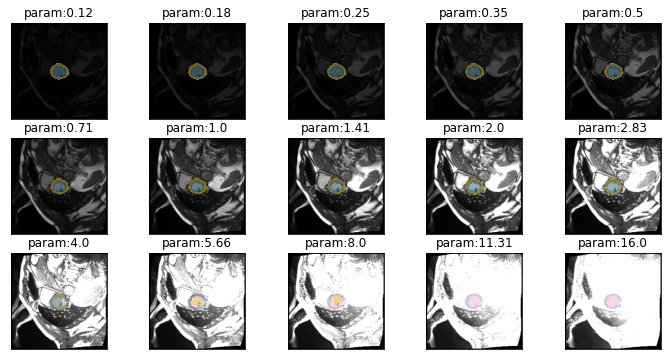

In [ ]:
plot_series(series, nrow=3, figsize=(12,6), overlay_truth = True)

In [ ]:
#| export
def eval_bright_series(image, mask, model, start=0.05, end=.95, step=0.05, param_name="brightness", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        brightnessTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_bright_series(img(), trueMask(), trainedModel, start=0, end=1.05, components=['bg','LV','MY'])
plot_eval_series(results)


  0%|          | 0/21 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_brightness_series(img(), trainedModel, step = np.sqrt(2)),
    "example/kaggle/brightness.gif",
    duration=500,
    param_name="brightness"
)

  0%|          | 0/11 [00:00<?, ?it/s]

![segmentation sensitivity to brightness](example/kaggle/brightness.gif)

### Contrast

In [ ]:
#| export
def contrastTransform(image, scale):
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance (scale)
    return image
def get_contrast_series(image, model, start=0.25, end=8, step=np.sqrt(2),log_steps = True, **kwargs):
    return get_generic_series(image,model,contrastTransform, start=start, end=end, step=step,log_steps = log_steps, **kwargs)

In [ ]:
series = get_contrast_series(img(), trainedModel, truth=trueMask(), start=1/8, end=16)

  0%|          | 0/15 [00:00<?, ?it/s]

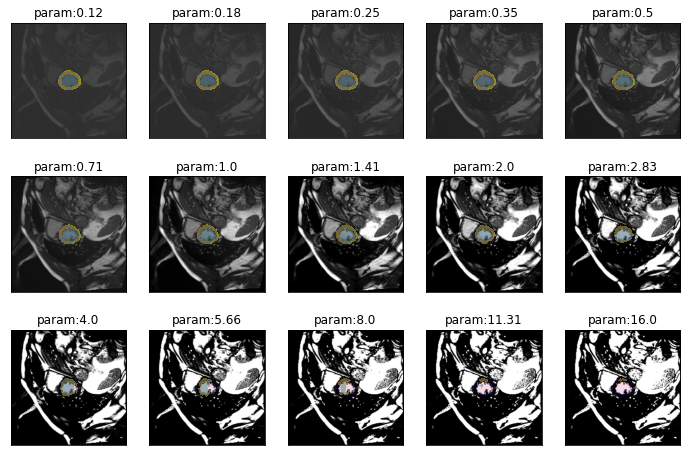

In [ ]:
plot_series(series, nrow=3, figsize=(12,8), overlay_truth = True)

In [ ]:
#| export
def eval_contrast_series(image, mask, model, start=0.25, end=8, step=np.sqrt(2), param_name="contrast", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        contrastTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_contrast_series(img(), trueMask(), trainedModel, start=0.25, end=8, step=np.sqrt(2), components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/6 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_contrast_series(img(), trainedModel,step=np.sqrt(2)),
    "example/kaggle/contrast.gif",
    duration=500,
    param_name="contrast"
)

  0%|          | 0/11 [00:00<?, ?it/s]

![segmentation sensitivity to contrast](example/kaggle/contrast.gif)

### Zoom

In [ ]:
#| export
def zoomTransform(image, zoom, finalSize= None):
    max_zoom = ((image.size[0]//2-1),(image.size[1]//2)-1)
    zoom_factor = []
    zoom_factor.append (round(max_zoom [0] * zoom)) #min_zoom = (0,0)
    zoom_factor.append (round(max_zoom [1] * zoom))
    zoom_factor_tuple=tuple(zoom_factor)
    image = ImageOps.crop (image, zoom_factor_tuple)
    image = ImageOps.pad (image ,(finalSize))
    return image

def get_zoom_series(image, model, start=0, end=1, step=.1, finalSize= None, **kwargs):
    if finalSize == None:
        finalSize = image.size
    if type(finalSize) == int:
        finalSize = (finalSize, finalSize)
    if end > 1:
        end = 1
    return get_generic_series(image,model,partial(zoomTransform,finalSize=finalSize), start=start, end=end, step=step, tfm_y = True, **kwargs)

In [ ]:
series = get_zoom_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/10 [00:00<?, ?it/s]

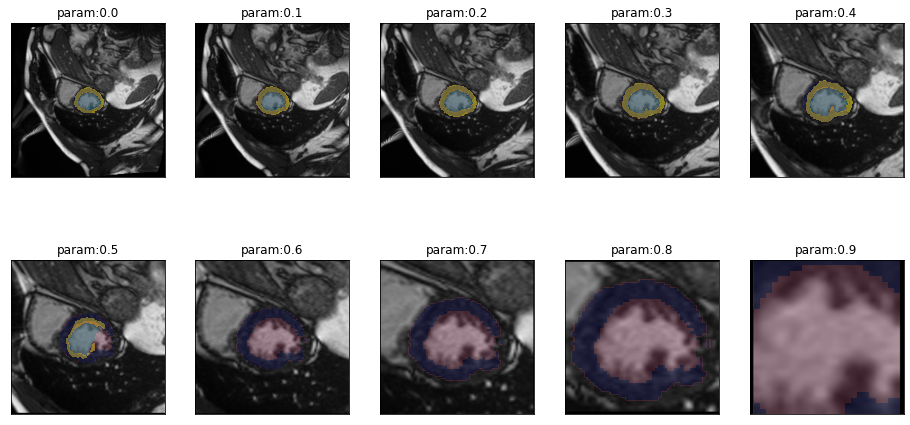

In [ ]:
plot_series(series, nrow=2, figsize=(16,8), overlay_truth = True)

In [ ]:
#| export
def eval_zoom_series(image, mask, model, step=0.1, start=0, end=1, finalSize=None, param_name="scale", **kwargs):
    finalmaskSize = finalSize
    if finalSize == None:
        finalSize = image.size
        finalmaskSize = mask.size
    if type(finalSize) == int:
        finalSize = (finalSize, finalSize)
        finalmaskSize = mask.size
    if end > 1:
        end = 1
    return eval_generic_series(
        image,
        mask,
        model,
        partial(zoomTransform,finalSize=finalSize),
        start=start,
        end=end,
        step=step,
        mask_transform_function=partial(zoomTransform,finalSize=finalmaskSize),
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_zoom_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/10 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_zoom_series(img(),trainedModel,start=0,end=1,step=0.1),
    "example/kaggle/zoom.gif",
    duration=500,
    param_name="scale"
)

  0%|          | 0/10 [00:00<?, ?it/s]

![segmentation sensitivity to zoom](example/kaggle/zoom.gif)

### Dihedral

In [ ]:
#| export
def dihedralTransform(image, sym_im):
    rot = [0, 90, 180, 270]
    flip = [False, True]
    dihedral = list (itertools.product (rot, flip))
    image = image.rotate (dihedral[sym_im][0])
    if dihedral [sym_im][1] == True:
        #image = ImageOps.flip(image)
        image = ImageOps.mirror(image)
    return image


def get_dihedral_series(image, model, start=0, end=8, step=1, **kwargs):
    return get_generic_series(image,model,dihedralTransform, start=start, end=end, step=step, tfm_y = True, **kwargs)

In [ ]:
series = get_dihedral_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/8 [00:00<?, ?it/s]

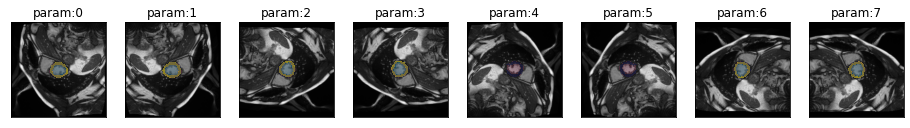

In [ ]:
plot_series(series, overlay_truth = True)

In [ ]:
#| export
def eval_dihedral_series(image, mask, model, start=0, end=8, step=1, param_name="k", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        dihedralTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        mask_transform_function=dihedralTransform,
        **kwargs
    )

In [ ]:
results = eval_dihedral_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results, chart_type="point")

  0%|          | 0/8 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_dihedral_series(img(), trainedModel),
    "example/kaggle/dihedral.gif",
    param_name="k",
    duration=1000
)

  0%|          | 0/8 [00:00<?, ?it/s]

![segmentation sensitivity to dihedral](example/kaggle/dihedral.gif)

### Resize

In [ ]:
#| export
def resizeTransform(image, size):
    #size_original = image.size
    image=ImageOps.contain (image, (size,size))
    #image = ImageOps.fit(image, size_original)
    return image


In [ ]:
#| export
def get_resize_series(image, model, start=10, end=200, step=30, **kwargs):
    return get_generic_series(image,model,resizeTransform, start=start, end=end, step=step, tfm_y = False, **kwargs)

In [ ]:
series = get_resize_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/7 [00:00<?, ?it/s]

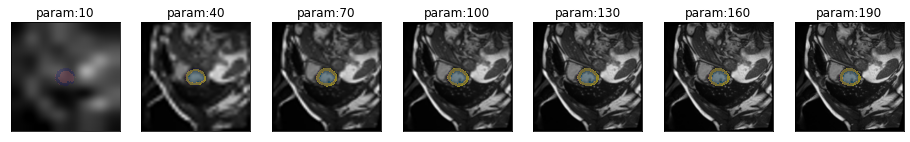

In [ ]:
plot_series(series, sharex=True, sharey=True, overlay_truth = True)

In [ ]:
#| export
def eval_resize_series(image, mask, model, start=22, end=3000, step=100, param_name="px", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        resizeTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        mask_transform_function=resizeTransform,
        **kwargs
    )

In [ ]:
results = eval_resize_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/30 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_resize_series(img(), trainedModel),
    "example/kaggle/resize.gif",
    param_name="px",
    duration=500
)

  0%|          | 0/7 [00:00<?, ?it/s]

![segmentation sensitivity to resizing](example/kaggle/resize.gif)

## More on Evaluation

The default score for evaluation is the Dice-Score calculated separately for each component.
In addition to Dice, `misas` provides functions for component-wise functions for precision and recall but you can easily define your own.

In [ ]:
results_dice = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_dice = plot_eval_series(results_dice, value_vars=['bg','LV','MY'], value_name="Dice Score")

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
results_precision = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'], eval_function=precision_by_component)
plot_precision = plot_eval_series(results_precision, value_vars=['bg','LV','MY'], value_name="Precision")

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
results_recall = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'], eval_function=recall_by_component)
plot_recall = plot_eval_series(results_recall, value_vars=['bg','LV','MY'], value_name="Recall")

  0%|          | 0/72 [00:00<?, ?it/s]

The objects returned by the plot function are `altair` graphs that can be further customized and combined

In [ ]:
plot_dice = plot_dice.properties(title="Dice")
plot_precision = plot_precision.properties(title="Precision")
plot_recall = plot_recall.properties(title="Recall")

In [ ]:
plot_dice & plot_precision & plot_recall

alt.VConcatChart(...)

In order to define your own evaluation function you need to define a function with the predicted and true masks as first and second parameter and the component to evaluate as third parameter.
Masks are of type ImageSegment and you can access the tensor data using the `.data` property.
This is an example on how to define specificity. This can than be passed as evaluation function.

In [ ]:
def specificity_by_component(predictedMask, trueMask, component = 1):
    specificity = 1.0
    pred = np.array(predictedMask) != component
    msk = np.array(trueMask) != component
    intersect = pred&msk
    total = np.sum(pred) + np.sum(msk)
    if total > 0:
        specificity = np.sum(intersect).astype(float) / msk.sum()
    return specificity.item()

In [ ]:
results_specificity = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'], eval_function=specificity_by_component)
plot_specificity = plot_eval_series(results_specificity, value_vars=['bg','LV','MY'], value_name="Specificity")
plot_specificity

  0%|          | 0/72 [00:00<?, ?it/s]

alt.Chart(...)

The specificity for the background class degrades so dramatically for rotations of around 180 degrees as the LV and MY classes are no longer detected at all. So there are no "true negatives" for the background class, consequently specificity for that class drops to zero.

## Confusion Matrices

Confusion matrices are useful to evaluate in more detail which classes the model gets wrong. To conveniently generate separate confusion matrices or series `misas` provides some convenience functions.

In [ ]:
series = get_rotation_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
#| export
def get_confusion(prediction, truth, max_class=None):
    if not max_class:
        max_class = max(np.array(prediction).max(), np.array(truth).max())
    # https://stackoverflow.com/a/50023660
    cm = np.zeros((max_class+1, max_class+1), dtype=int)
    np.add.at(cm, (np.array(prediction), np.array(truth)), 1)
    return cm

The `get_confusion` function returns a two dimensional `numpy` array with counts for each class combination.
The true class is along the columns and the predicted class along the rows. The number of classes is derived from the data if not provided as `max_class` parameter. This parameter is important if the given instance of prediction and truth does not contain all available classes.

In [ ]:
cm = get_confusion(series[0][2], series[0][3])
cm

array([[63862,    22,    37],
       [    8,   756,    76],
       [  129,    28,   618]])

This matrix shows that there are 754 pixels classified correctly as "LV" (class=1). However, there are also 17 pixels that are in reality "LV" but predicted as "MY". Accordingly, there are 68 pixels that are "MY" but predicted as "LV".

Looking at tables is much less convenient and informative than looking at graphics so let's plot this matrix

In [ ]:
#| export
def plot_confusion(confusion_matrix, norm_axis=0, components=None, ax=None, ax_label=True, cmap="Blues"):
    cm = confusion_matrix / confusion_matrix.sum(axis=norm_axis, keepdims=True)
    if not components:
        components = ["c" + str(i) for i in range(cm.shape[0])]
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(cm, cmap=cmap)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(components)))
    ax.set_yticks(np.arange(len(components)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(components)
    ax.set_yticklabels(components)
    
    # label axes
    if ax_label:
        ax.set_xlabel("truth")
        ax.set_ylabel("prediction")
    
    # label cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, round(cm[i, j],2),
                           ha="center", va="center")
    
    return ax

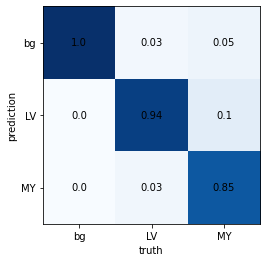

In [ ]:
_ = plot_confusion(cm, components=["bg","LV","MY"])

This is the confusion matrix for one image. Next we want to look at the confusion matrix for a full series of transformed (in this case rotated) images.

In [ ]:
#| export
def plot_confusion_series(
        series,
        nrow=1,
        figsize=(16,6),
        param_name='param',
        cmap="Blues",
        components=None,
        norm_axis=0,
        **kwargs
    ):
    fig, axs = plt.subplots(nrow,int(np.ceil(len(series)/nrow)),figsize=figsize,**kwargs)
    for element, ax in zip(series, axs.flatten()):
        param,img,pred,truth = element
        cm = get_confusion(pred,truth)
        plot_confusion(cm, ax=ax, components=components, ax_label=False, norm_axis=norm_axis, cmap=cmap)

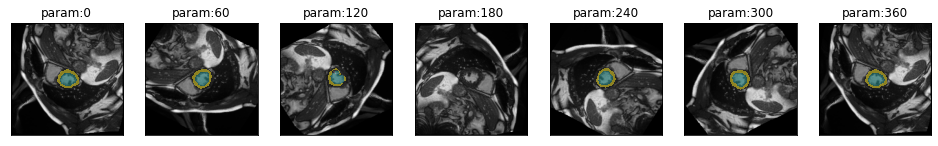

In [ ]:
plot_series(series,figsize=(16.5,6))

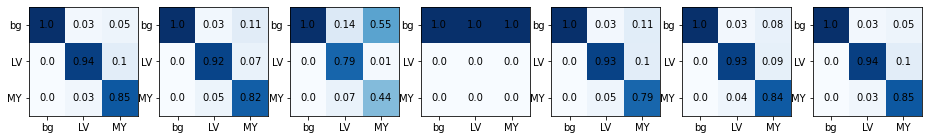

In [ ]:
plot_confusion_series(series, components=['bg','LV','MY'])